In [6]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import colormaps as cmaps
import os
import scipy as sp
from scipy.ndimage.interpolation import rotate
from magpie_data import PolarimetryMap2, FaradayMap2, NeLMap2, Interferogram, OpticalFrames
import scipy.constants as c
from mcerp import N, umath, Gamma
from bdots import *
import pickle
import csv

class TS_fibre_data:
    def __init__(self, fn):
        shift=[]
        Background=[]
        Response=[]
        Shot=[]
        Fit=[]

        with open(fn, 'r') as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            next(reader)
            next(reader)
            for row in reader:
                shift.append(float(row[0]))
                Background.append(float(row[1]))
                Response.append(float(row[2]))
                Shot.append(float(row[3]))
                Fit.append(float(row[4]))

        self.shift=np.asarray(shift)
        self.Background=np.asarray(Background)
        self.Response=np.asarray(Response)
        self.Shot=np.asarray(Shot)
        self.Fit=np.asarray(Fit)

# Sample Spectra

In [58]:
%cd "~\Google Drive\MAGPIE\data\2015\s0611_15\s0611_15 TS t240ns\shot"
ts=np.loadtxt('s0611_15 shot (corrupted line removed).asc')
ts=np.rot90(ts)
roi=np.flipud(ts[:270,980:1056])

%cd "~\Google Drive\MAGPIE\data\2015\s0611_15\s0611_15 TS t240ns"
A1=TS_fibre_data("s0611_15_1A_data_and_fit.dat")
A8=TS_fibre_data("s0611_15_8A_data_and_fit.dat")

C:\Users\jdhare\Google Drive\MAGPIE\data\2015\s0611_15\s0611_15 TS t240ns\shot
C:\Users\jdhare\Google Drive\MAGPIE\data\2015\s0611_15\s0611_15 TS t240ns


<IPython.core.display.Javascript object>


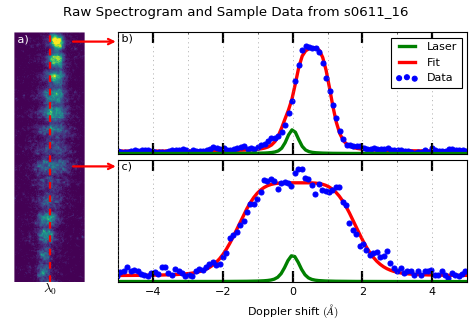

In [134]:
fig=plt.figure(figsize=(5.9,4))

ax1=fig.add_axes([0.0, 0.12, 0.2, 0.78])#l,b,w,h
ax1.imshow(roi, clim=[620,900], cmap=cmaps.viridis, interpolation='none')
ax1.plot([38,38],[0,270], lw=2, color='red', ls='--')
ax1.set_ylim([0,270])
ax1.axis('off')
ax1.text(x=38, y=0, va='top',ha='center',s=r'$\lambda_0$', fontsize=12)
ax1.text(x=0.1, y=0.99, va='top',ha='left',s=r' a)', color='white',fontsize=10,transform=ax1.transAxes)


ax2=fig.add_axes([0.25, 0.52, 0.74, 0.38])#l,b,w,h
a=ax2

f=A1
a.plot(f.shift, f.Response*0.4, lw=3, color='green', label='Laser')
a.plot(f.shift, f.Fit, lw=3, color='red', label='Fit',zorder=1)
a.scatter(f.shift, f.Shot, color='blue', marker='o', label='Data',zorder=2)
a.set_ylim([0,None])
a.set_xlim([-5,5])
a.tick_params(labelsize=10, pad=5, length=10, width=2)
a.set_yticks([])
a.set_xticklabels([])

a.xaxis.set_minor_locator(MultipleLocator(1))
a.grid(which='minor', color='gray',linestyle=':')
a.text(x=0, y=0.99, va='top',ha='left',s=r' b)',transform=a.transAxes,fontsize=10)


a.legend(fontsize=10, loc=1)

ax3=fig.add_axes([0.25, 0.12, 0.74, 0.38])#l,b,w,h
a=ax3

f=A8
a.plot(f.shift, f.Response*0.08, lw=3, color='green', label='Laser')
a.plot(f.shift, f.Fit, lw=3, color='red', label='Fit',zorder=1)
a.scatter(f.shift, f.Shot, color='blue', marker='o', label='Data',zorder=2)
a.set_ylim([0,None])
a.set_yticks([])
a.set_xlim([-5,5])
a.xaxis.set_minor_locator(MultipleLocator(1))
a.grid(which='minor', color='gray',linestyle=':')
a.text(x=0, y=0.99, va='top',ha='left',s=r' c)',transform=a.transAxes,fontsize=10)


a.set_xlim([-5,5])
a.tick_params(labelsize=10, pad=5, length=10, width=2)

a.set_xlabel(r'Doppler shift $(\AA)$',fontsize=10)

fig.suptitle('Raw Spectrogram and Sample Data from s0611_16', fontsize=12)

a.annotate('',xy=(0.25,0.87),xycoords='figure fraction',xytext=(0.15,0.87),
             arrowprops=dict(arrowstyle='->',fc='red',ec="red",lw=2))

a.annotate('',xy=(0.25,0.48),xycoords='figure fraction',xytext=(0.15,0.48),
             arrowprops=dict(arrowstyle='->',fc='red',ec="red",lw=2))



In [135]:
th_folder=r'~\Google Drive\MAGPIE\thesis\images'
fn='chapter5_s0611_15_thomson_inflow.pdf'
p=os.path.expanduser(os.path.join(th_folder,fn))
fig.savefig(p, dpi=400)